<a href="https://colab.research.google.com/github/Icyfire18/Face_Counting/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORT REQUIRED PACKAGES**

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
import random
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
import shutil
from shutil import copy
%matplotlib inline
print(tf.__version__)

2.3.0


**IMPORT DATASET**

In [3]:
!git clone https://github.com/Icyfire18/Face_Counting.git

Cloning into 'Face_Counting'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 8235 (delta 0), reused 0 (delta 0), pack-reused 8232
Receiving objects: 100% (8235/8235), 379.69 MiB | 33.40 MiB/s, done.
Resolving deltas: 100% (14/14), done.
Checking out files: 100% (8202/8202), done.


In [4]:
!ls

Face_Counting  sample_data


In [5]:
bbox_train = pd.read_csv("Face_Counting/bbox_train.csv")
bbox_train.head()

,Name,width,height,xmin,ymin,xmax,ymax
0,10001.jpg,612,408,192,199,230,235
1,10001.jpg,612,408,247,168,291,211
2,10001.jpg,612,408,321,176,366,222
3,10001.jpg,612,408,355,183,387,214
4,10002.jpg,612,408,339,165,378,202


In [6]:
train = pd.read_csv("Face_Counting/train.csv")
train.head()

,Name,HeadCount
0,10001.jpg,4
1,10002.jpg,4
2,10003.jpg,2
3,10004.jpg,3
4,10006.jpg,4


In [7]:
df1 = pd.DataFrame(train)
df1.groupby('HeadCount').size()

HeadCount
1       52
2     1069
3     1424
4     1238
5      810
6      472
7      254
8      136
9       93
10      47
11      37
12      23
13      20
14      15
15       7
16       5
17       4
18       6
19       2
20       4
21       1
22       2
23       2
24       3
25       1
28       2
29       1
31       2
77       1
dtype: int64

In [8]:
img_dir="/content/Face_Counting/dataset/"
len(os.listdir(img_dir))

8197

In [9]:
test=pd.read_csv('Face_Counting/test_Rj9YEaI.csv')
test.head()

,Name
0,10005.jpg
1,10009.jpg
2,10015.jpg
3,10022.jpg
4,10023.jpg


In [10]:
def show_images(images, cols = 1, titles = None):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if plt.imread(image).ndim == 3:
            plt.gray()
        plt.imshow(plt.imread(image))
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    fig.tight_layout()
    plt.show()

In [11]:
img_dir

'/content/Face_Counting/dataset/'

In [12]:
images = []
for i in range(len(train)):
  images.append(img_dir+train['Name'][i])

In [13]:
titles =[]
for i in range(len(train)):
  titles.append("Num Of Head Count:"+str(train['HeadCount'][i]))

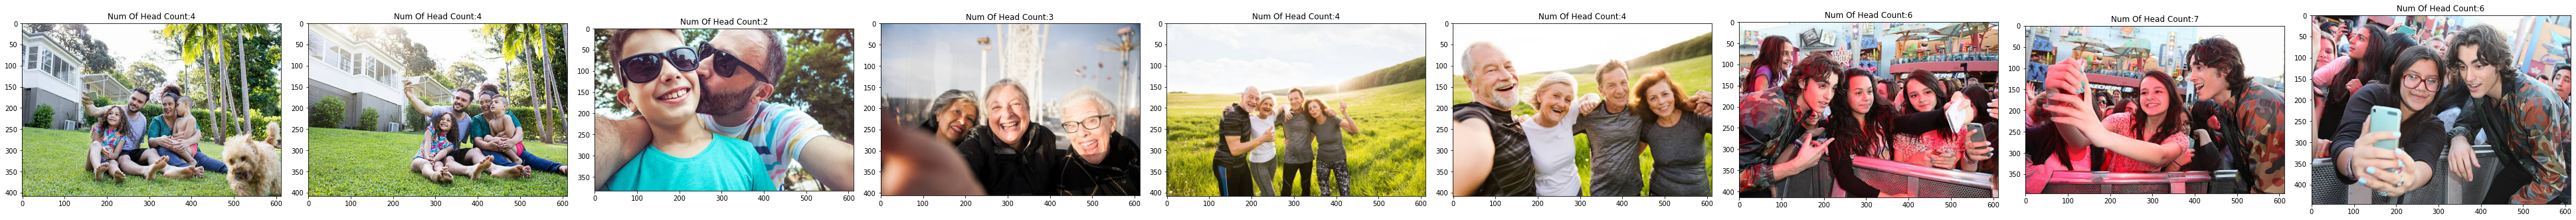

In [14]:
show_images(images[:9],titles=titles[:9])

In [15]:
os.mkdir('/content/Face_Counting/train/')
os.mkdir('/content/Face_Counting/valid/')
os.mkdir('/content/Face_Counting/model/')

In [16]:
train.shape[0]*.10

573.3000000000001

In [17]:
valid_imgs = random.sample(train['Name'].tolist(),574)
train_imgs = list(set(train['Name'].tolist()) - set(valid_imgs))

In [19]:
for i in range(len(train_imgs)):
    shutil.copy(img_dir+train_imgs[i],'/content/Face_Counting/train/')
    
for j in range(len(valid_imgs)):
    shutil.copy(img_dir+valid_imgs[j],'/content/Face_Counting/valid/')
print (len(os.listdir('/content/Face_Counting/train/')))
print (len(os.listdir('/content/Face_Counting/valid/')))

5159
574


In [18]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /content/Face_Counting/model/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-08-19 10:49:34--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.128, 173.194.74.128, 172.217.219.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/content/Face_Counting/model/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/content/Face_Count 100%[===================>]  83.84M   197MB/s    in 0.4s    

2020-08-19 10:49:34 (197 MB/s) - ‘/content/Face_Counting/model/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



Create an instance of the inception model from the local pre-trained weights

In [20]:
local_weights_file = '/content/Face_Counting/model/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False
  
# Print the model summary
pre_trained_model.summary()


Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [21]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [22]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_loss')<0.1):
      print("\nReached 0.50 loss so cancelling training!")
      self.model.stop_training = True
        
callbacks = myCallback()

In [23]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adadelta
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.40
x = layers.Dropout(0.40)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='linear')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = Adadelta(lr=0.001), 
              loss = 'mean_squared_error')

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [24]:
train_df = pd.DataFrame(columns=['Name'])
train_imgs = os.listdir('/content/Face_Counting/train/')
train_df['Name'] = train_imgs
train_df = pd.merge(train_df,train)
print (train_df.shape)
train_df.head()

(5159, 2)


,Name,HeadCount
0,16531.jpg,4
1,16666.jpg,4
2,14835.jpg,6
3,14248.jpg,5
4,14203.jpg,3


In [25]:
valid_df = pd.DataFrame(columns=['Name'])
valid_imgs = os.listdir('/content/Face_Counting/valid/')
valid_df['Name'] = valid_imgs
valid_df = pd.merge(valid_df,train)
print (valid_df.shape)
valid_df.head()

(574, 2)


,Name,HeadCount
0,15679.jpg,3
1,12080.jpg,5
2,15636.jpg,4
3,11448.jpg,3
4,15103.jpg,3


In [26]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                  fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator_df = train_datagen.flow_from_dataframe(dataframe=train_df, 
                                                       directory='/content/Face_Counting/train/', 
                                                       x_col="Name", y_col="HeadCount", class_mode="other", target_size=(150,150), batch_size=20)  

# Flow validation images in batches of 20 using test_datagen generator
validation_generator_df =  test_datagen.flow_from_dataframe( dataframe=valid_df, 
                                                            directory='/content/Face_Counting/valid/', 
                                                            x_col="Name", y_col="HeadCount", 
                                                            class_mode="other", target_size=(150,150), batch_size=20)

Found 5159 validated image filenames.
Found 574 validated image filenames.


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.6/logging/__init__.py", line 994, in emit
    msg = self.format(record)
  File "/usr/lib/python3.6/logging/__init__.py", line 840, in format
    return fmt.format(record)
  File "/usr/lib/python3.6/logging/__init__.py", line 577, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.6/logging/__init__.py", line 338, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/usr/local/lib/python

In [27]:
history = model.fit_generator(
            train_generator_df,
            validation_data = validation_generator_df,
#             steps_per_epoch = 100,
            epochs = 10,
#             validation_steps = 50,
            verbose = 2,
            callbacks=[callbacks])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
258/258 - 75s - loss: 16.3359 - val_loss: 9.4872
Epoch 2/10
258/258 - 67s - loss: 7.8642 - val_loss: 7.2550
Epoch 3/10
258/258 - 67s - loss: 7.2739 - val_loss: 6.9922
Epoch 4/10
258/258 - 66s - loss: 7.0965 - val_loss: 6.8458
Epoch 5/10
258/258 - 66s - loss: 6.9142 - val_loss: 6.6317
Epoch 6/10
258/258 - 65s - loss: 6.7145 - val_loss: 6.4918
Epoch 7/10
258/258 - 67s - loss: 6.6800 - val_loss: 6.3171
Epoch 8/10
258/258 - 68s - loss: 6.5089 - val_loss: 6.2045
Epoch 9/10
258/258 - 68s - loss: 6.4029 - val_loss: 6.0318
Epoch 10/10
258/258 - 69s - loss: 6.2846 - val_loss: 5.9220


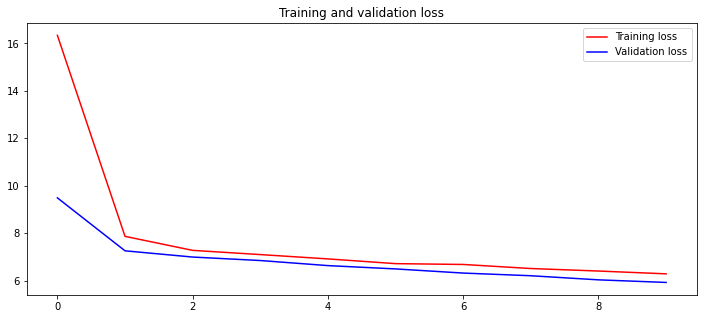

<Figure size 432x288 with 0 Axes>

In [28]:
plt.figure(figsize=(12,5))
val_loss = history.history['val_loss']
loss = history.history['loss']


epochs = range(len(val_loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()